#### Test functions for Morse wave (need to inlcude lines/conditions for when beta=0)
##### checking decay of signals 

#### What is a wavelet?
- Oscillatory, time-localised function
- Complex exponential multiplied by a Gaussian (Morlet wavelet)
    - The complex exponential generates the oscillation
    - The Gaussian controls the time localisation

#### Morse wavelet
- superfamily of analytic wavelets

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

from scipy import signal
from scipy.special import gammaln,gamma
from math import log, floor, exp

In [2]:
#apply boubdary conditions to data before transform 
#here as zero padding (no detrending of data) - need to implement periodic data 

def zero_pad(x):
    
    #get original length of data
    sizex = np.size(x)
    M=sizex
    
    #get index of first and last value of original data 
    #need to change to account for NaNs in data (e.g where there is topo)
    
    a = 0
    b=len(x)
    
    y = np.zeros(sizex*3)
    
    index=np.arange(a,b)
    indexy= np.arange(M+a-len(index), M + (2*len(index)) + a)
    
    #pad with zeros 
    y[indexy] = np.concatenate((0*x,x,0*x))
    
    return(y)


In [3]:
# compute dimensionless time-domain window width (p) 
def morseprops(ga,be):
    p = np.sqrt(be*ga)
    skew = (ga-3)/p
    kurt = (3-skew)**2 - (2/p**2)
    
    return(p)


In [4]:
#compute modal or peak frequency
def morsefreq(ga,be):  
    if be==0:
        fm = log(2)**(1/ga)
        
    else:
        fm = np.exp((1/ga)*(log(be) - log(ga)))
        
    return(fm)


In [5]:
# compute low frequency cutoff (eqn c3 in Lilly 2017)
def morsespace_low(ga,be,r,N):
    
    p = morseprops(ga,be);
    fmin = (2*np.sqrt(2)*p*r)/N
    
    return(fmin)


In [6]:
# compute highest frequency cutoff
def morsehigh(ga,be,alpha):
    
    N = 10000;
    omhigh = np.linspace(0,np.pi,N)
    
    f = 0*ga
    om = morsefreq(ga,be)*np.pi/omhigh
    
    #use logs to avoid errors for really small gammas
    lnpsi1 = (be/ga) * np.log((exp(1)*ga)/be)
    lnpsi2 = be*np.log(om) - om**ga
    lnpsi = lnpsi1 + lnpsi2
    index = np.argwhere(log(alpha) - lnpsi < 0)[0]

    fmax = omhigh[index]
    
    return(fmax)
    
        

In [7]:
# generates frequeny array for the generalised Morse array 
# fs has units of radians per sample point (frequency resolution is compatible with the bandwidth)

def morsespace(ga,be,N):
    #using default values as from Lily(2017) for 
    low=(5,N) #5 is packing number (five wavelet footprints span the time series)
    high=(0.1,np.pi)
    D = 4     

    fhigh = min(high[1],morsehigh(ga,be,high[0]))
    flow = max(0,morsespace_low(ga,be,low[0],low[1]))
     
    r = 1 + (1/(D*morseprops(ga,be)))
    N = floor((log(fhigh/flow))/(log(r)))
    fs = fhigh*np.ones((N+1))/(r**np.arange(0,N+1))
    
    return(fs)



In [8]:
#generalised laguerre polynomial 
#as from Olhede and Walden (2002) - gamma function just below eqn (10)
#playing with gamma function properties 
#log of gamma works better apparently in matlab, not sure about python

def laguerre(x,k,c):
    
    for m in np.arange(0,k+1):
        coeff_exp = gammaln(k+c+1) - gammaln(c+m+1) - gammaln(k-m+1);
        fact = np.exp(coeff_exp)
        y = ((-1)**m)*fact*(x**m)/gamma(m+1) 
        
    return(y)
        

In [9]:
#Returns the generalized Morse wavelet amplitude or a-function.

def morseafun(k,ga,be,str):
    
    if str == "ban":
        #amplitude using bandpass normalisation
        om=morsefreq(ga,be)
        a=(2)/(np.exp(be)*np.log(om) - om**ga)
    
    elif str == "ene":
        #amplitude using energy normalisation
        r = (2*be+1)/ga
        a = (2*np.pi*ga*(2**r)*np.exp(gammaln(k) - gammaln(k+r-1)))**0.5

    return(a)


In [10]:
#computes the standard geheralised Morse wavelet (primary wavelet)
#takes in psizero (when omega=0)
def morsewave_first_family(fact,N,K,ga,be,om,psizero,str):
    
    #small k as specified in Lilly (here k=0, when K=1)
    k = K-1
    
    l = be- 0.5
    m = ga
    r = (2*be+1)/ga
    c = (2*l + 2)/(m-1)
    
    L = 0*om
    index = np.arange(0,int(N/2)+1) #only need to take half (something will be flipped after??)

    if str == "ene":
        A = morseafun(k+1,ga,be,str)
        coeff = np.sqrt(1/fact)*A
    
    elif str == "ban":
        if be == 0:
            coeff = 1
        
        else:
            coeff = np.sqrt(exp(gammaln(r)+ gammaln(k+1) - gammaln(k+r)))
        
    L[index] = laguerre(2*om[index]**ga,k,c) 
    psif  = coeff * psizero * L
    
    return(psif)


In [11]:
#computes primary Morse wavelet in frequency domain using equation (10) of Olhede 
#takes in one frequency/scale (fs is scalar) at a time
def morsewave_fs(N,K,ga,be,fs,str):
    l = be - 0.5
    m = ga
    fo = morsefreq(ga,be)
    fact = fs/fo
    om = 2*np.pi*np.linspace(0,1-(1/N),N)/fact

    #compute psizero that should be of length N
    #energy normalisation
    if str == "ene":
        if be == 0:
            psizero = np.exp(-om**m)
        
        else:
            psizero = np.exp(l*np.log(om) - om**m)
        
    #bandpass normalisation 
    elif str == "ban":
        if be == 0:
            psizero = np.exp(-om**ga)
        
        else:
            #calculation for preventing things from blowing up apparently 
            psizero = 2 * np.exp(-be* np.log(fo) + fo**ga + be*np.log(om) - om**ga)
            
    psif_fs = morsewave_first_family(fact,N,K,ga,be,om,psizero,str)
    
    return(psif_fs)

    

In [12]:
#computes primary Morse wavelet in frequency domain using equation (10) of Olhede 
#takes in all scales at a time (fs is an array of scales)
def morsewave(N,K,ga,be,fs,str):
    
    psif = np.zeros((N,np.shape(fs)[0],np.shape(fs)[1]))
    
    for ii in np.arange(np.shape(fs)[0]):
        for jj in np.arange(np.shape(fs)[1]):
        
            psif_fs = morsewave_fs(N,K,ga,be,abs(fs[ii,jj]),str)
            psif[:,ii,jj] = psif_fs
        
    return(psif)


### Create synthetic 2D waves (with small wavelengths that can be resolved)
- Investigate different wavelenghts with different spatial variation
- Morse wavelet cannot get out directionality (so direction of propagation will not be detected)

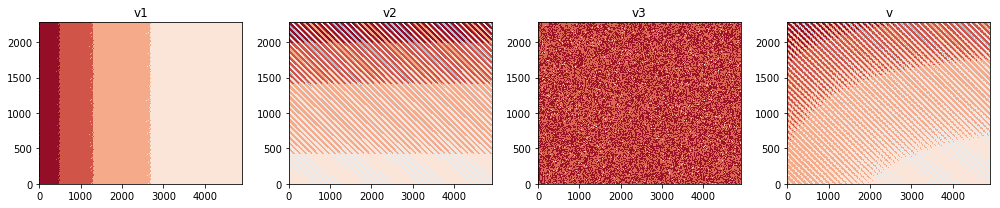

In [13]:
#create synthetic waves 
Nx = 1000
Ny = 500 

phi = 30
phi1 = 25
phi2 = 60
phi3 = phi

#meshgrid as defined from interpolated grid of mitgcm data 
dx = 4913.2902516
dy = 4565.27698988
x = np.arange(0,(Nx*dx),dx)
y = np.arange(0,(Ny*dy),dy)
Y, X = np.meshgrid(y, x)

amp1 = 100
amp2 = 45
amp3 = 1.5 



#from Simmons:
# l >> k ,mode 1 ~ 500km and mode 3 ~ 200km
phi1 = np.radians(phi1)
lam1 = 25e3
k1 = 2*np.pi/lam1
kx1 = k1 * np.cos(phi1)
ky1 = k1 * np.sin(phi1)

phi2 = np.radians(phi2)#angle between wave propagation and x-axis 
lam2 = 70e3
k2 = 2*np.pi/lam2
kx2 = k2 * np.cos(phi2)
ky2 = k2 * np.sin(phi2)

phi3 = np.radians(phi3)#angle between wave propagation and x-axis 
lam3 = 100e3
k3 = 1/lam3
kx3 = k3 * np.cos(phi2)
ky3 = k3 * np.sin(phi2)

#create waves 
v1 = amp1*np.sin(kx1*X + ky1*Y)*np.exp(-5e-7*X)
v2 = amp2*np.sin(kx2*X + ky2*Y)*np.exp(7e-7*Y)
v3 = np.random.rand(Nx,Ny)
v = v1 + v2 + v3

#create figure
fig, ax = plt.subplots(1,4,figsize=(14, 3))
ax[0].contourf(x/1e3,y/1e3,np.transpose(v1),cmap="RdBu_r")
ax[0].set_title("v1")

ax[1].contourf(x/1e3,y/1e3,np.transpose(v2),cmap="RdBu_r")
ax[1].set_title("v2")

ax[2].contourf(x/1e3,y/1e3,np.transpose(v3),cmap="RdBu_r")
ax[2].set_title("v3")

ax[3].contourf(x/1e3,y/1e3,np.transpose(v),cmap="RdBu_r")
ax[3].set_title("v")

plt.tight_layout()
plt.show()

#### blow up of v2 (again directionality will not be detected)

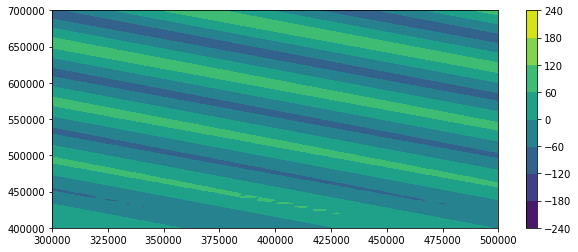

In [14]:
fig, ax = plt.subplots(1,figsize=(10, 4))
plt.contourf(x,y,np.transpose(v2))
plt.xlim(0.3e6,0.5e6)
plt.ylim(0.4e6,0.7e6)
plt.colorbar()
plt.show()

### Form grid for 2D Morse
- Here using fftfreq (don't forget to centre frequency/wavenumber=0 using fftshift) 
- note sampling size (dx,dy) not included here

In [16]:
#grid for 2D fft 
fx = np.fft.fftshift(np.fft.fftfreq(Nx)) #returns cycles per unit of sampling (2pi already included) #sampling interval not included here
fy = np.fft.fftshift(np.fft.fftfreq(Ny))

#meshgrid of fx and fy
FY, FX = np.meshgrid(fy,fx)

grid_fxfy = np.sqrt(FX**2 + FY**2)

#### Synthetic waves in the wavenumber spectrum

/Users/jemimarama/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:2809: ComplexWarning: Casting complex values to real discards the imaginary part
  order=order, subok=True, ndmin=ndmin)


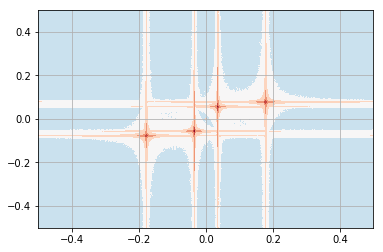

In [17]:
v_fft = np.fft.fft2(v)
v_fft = np.fft.fftshift(v_fft,axes={0,1}) #recentre 0 
plt.contourf(fx,fy,np.transpose(np.log10(v_fft)),cmap="RdBu_r")
plt.grid()
plt.show()


#### Define wavelet shape 
- beta controls low freq. behaviour (and overlap of bandpass filters for different frequencies?)
- gamma controls high freq. decay and symmetry of wavelet
- gamma = 3 is close to a Gaussian envelope, closest to Morlet shape, highest time-frequency concentration (smallest Heisenberg Area)
- fs computed using Morsespace as from jWavelet package 


*** for non-square areas and unequal sampling
intervals we use the smallest numerical values of Nx and Ny, and of
$\Delta$x and $\Delta$y.***

In [18]:
K=1 # 1: first family of Morse wavelet
ga = 3 #3 ensures symmetry of wavelet
be = 24
str = "ene" #energy normalisation (can also be bandpass)
#scales (for min and max wavenumber that can be resolved)
fs = morsespace(ga,be,Ny)
fs =  np.flip(fs,axis=0)


/Users/jemimarama/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/jemimarama/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in subtract
  if sys.path[0] == '':
/Users/jemimarama/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in less
  


#### Wavenumbers that can be resolved (as per Morsespace) falls outside of ellipse 
- still need to define threshold (Rayleigh frequency) for resolvable frequencies/wavenumbers

/Users/jemimarama/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:2809: ComplexWarning: Casting complex values to real discards the imaginary part
  order=order, subok=True, ndmin=ndmin)


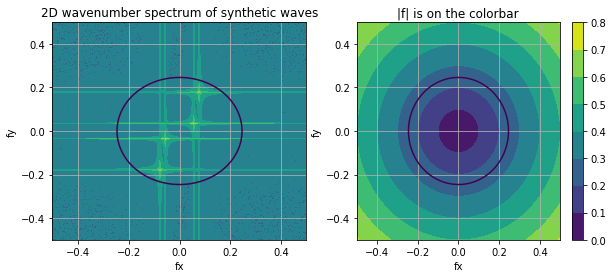

In [19]:
fig, ax = plt.subplots(1,2,figsize=(10, 4))

ax[0].contourf(fy,fx,np.log2(v_fft * np.conj(v_fft)))
ax[0].contour(fy,fx,grid_fxfy,[0,min(fs),max(fs)])
ax[0].grid()
ax[0].set_title("2D wavenumber spectrum of synthetic waves")
ax[0].set_xlabel("fx")
ax[0].set_ylabel("fy")

fig1 = ax[1].contourf(fy,fx,grid_fxfy)
fig.colorbar(fig1,ax=ax[1])
ax[1].contour(fy,fx,grid_fxfy,[0,min(fs),max(fs)])
ax[1].grid()
ax[1].set_title("|f| is on the colorbar")
ax[1].set_xlabel("fx")
ax[1].set_ylabel("fy")
plt.show()



### Compute Morsewave 

In [20]:
#use grid_fxfy
N = len(fy) #N is the number of scales available (will depend on fmin and fmax)
psif = morsewave(N,K,ga,be,grid_fxfy,str)

/Users/jemimarama/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log
/Users/jemimarama/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/jemimarama/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/Users/jemimarama/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in subtract
/Users/jemimarama/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in multiply
  del sys.path[0]
/Users/jemimarama/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars


#### If there is any NaN in the computed Morsewave, quick fix is to replace NaN by zero 

In [21]:
#replace NaNs with zeros
psif = np.nan_to_num(psif, copy=True)


#### Plot wavelet at two different scales 

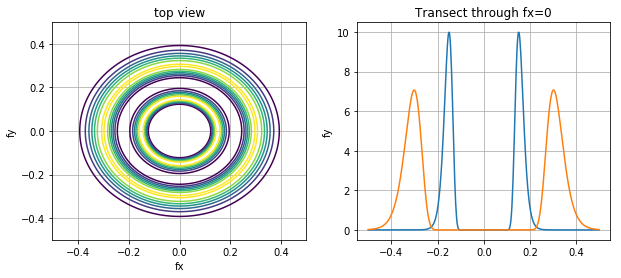

In [22]:
fig, ax = plt.subplots(1,2,figsize=(10, 4))
ss1 = 12
ss2 = 24

ax[0].contour(fy,fx,psif[ss1,:,:])
ax[0].contour(fy,fx,psif[ss2,:,:])
ax[0].grid()
ax[0].set_title("top view")
ax[0].set_xlabel("fx")
ax[0].set_ylabel("fy")

ax[1].plot(fy,psif[ss1,499,:])
ax[1].plot(fy,psif[ss2,499,:])
ax[1].grid()
ax[1].set_title("Transect through fx=0")
ax[1].set_ylabel("fy")


plt.show()

#### If wavelet threshold (smallest resolvable wavenumber) has not been taken into account - perform next step 
- for wavelet of corresponding scales that are not resolvable (those smaller than the defined threshold) - set wavelet to nan

### Apply wavelet on signal

In [23]:
#compute frequency spectrum of data 
v_fft = np.fft.fft2(v,axes=(0,1))
v_fft = np.fft.fftshift(v_fft,axes={0,1}) #recentre 0 

v_wf = np.zeros(np.shape(psif))
for ss in np.arange(np.shape(psif)[0]):
    v_wf[ss,:,:] = np.fft.ifft2(v_fft * psif[ss,:,:],axes=(0,1))

/Users/jemimarama/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  import sys


### Relating scales to wavelength (specify wavelength and extract out signal)
- fx and fy not computed using sampling interval - include in computation

In [24]:
#finding fmax? |f| dependent on fx and fy 
# fx and fy did not take into account dx and dy
f_scales = []
for ss in np.arange(np.shape(psif)[0]):
    if ss == 0:
        f = 0
    else:
        ind_max_x, ind_max_y = np.where(psif[ss,:,:] == np.max(psif[ss,:,:]))
        fx_ss = fx[ind_max_x[0]]/dx
        fy_ss = fy[ind_max_y[0]]/dy
        f = np.sqrt(fx_ss**2 + fy_ss**2)
    f_scales.append(f)
        
f_scales = np.array(f_scales)
lambda_scales = 1/f_scales


/Users/jemimarama/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


### Plot out filtered wavelength - decay pattern is resolved by wavelet

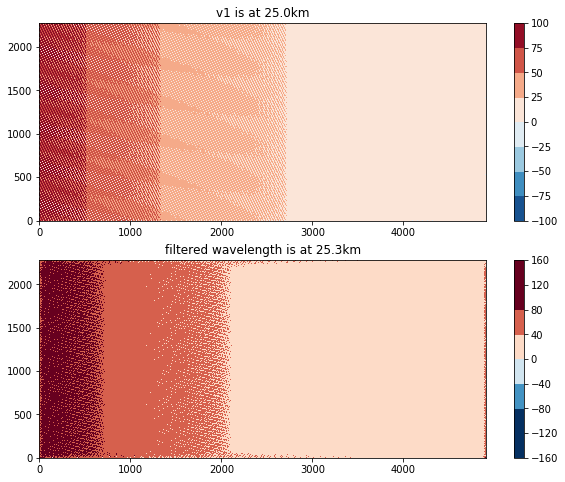

In [33]:
#calculate index closer to defined wavelength
wavelength_sel = lam1
wave_ind = int(np.where(np.abs(lambda_scales - wavelength_sel) == np.min(np.abs(lambda_scales - wavelength_sel)))[0])

fig, ax = plt.subplots(2,1,figsize=(10, 8))

fig0 = ax[0].contourf(x/1e3,y/1e3,np.transpose(v1),cmap="RdBu_r")
fig.colorbar(fig0,ax=ax[0])
ax[0].set_title("v1 is at {}km".format(lam1/1e3))

fig1 = ax[1].contourf(x/1e3,y/1e3,np.transpose(v_wf[wave_ind,:,:]/(2*np.pi)),cmap="RdBu_r",vmin=-100,vmax=100)
fig.colorbar(fig1,ax=ax[1])
ax[1].set_title("filtered wavelength is at {:.1f}km".format(lambda_scales[wave_ind]/1e3))
plt.show()


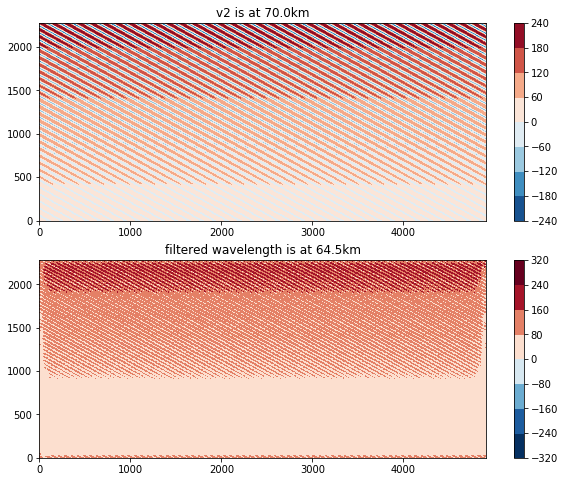

In [34]:
#calculate index closer to defined wavelength
wavelength_sel = lam2
wave_ind = int(np.where(np.abs(lambda_scales - wavelength_sel) == np.min(np.abs(lambda_scales - wavelength_sel)))[0])

fig, ax = plt.subplots(2,1,figsize=(10, 8))

fig0 = ax[0].contourf(x/1e3,y/1e3,np.transpose(v2),cmap="RdBu_r")
fig.colorbar(fig0,ax=ax[0])
ax[0].set_title("v2 is at {}km".format(lam2/1e3))

fig1 = ax[1].contourf(x/1e3,y/1e3,np.transpose(v_wf[wave_ind,:,:]/(2*np.pi)),cmap="RdBu_r",vmin=-240,vmax=240)
fig.colorbar(fig1,ax=ax[1])
ax[1].set_title("filtered wavelength is at {:.1f}km".format(lambda_scales[wave_ind]/1e3))
plt.show()


#### Blow up of filtered v1


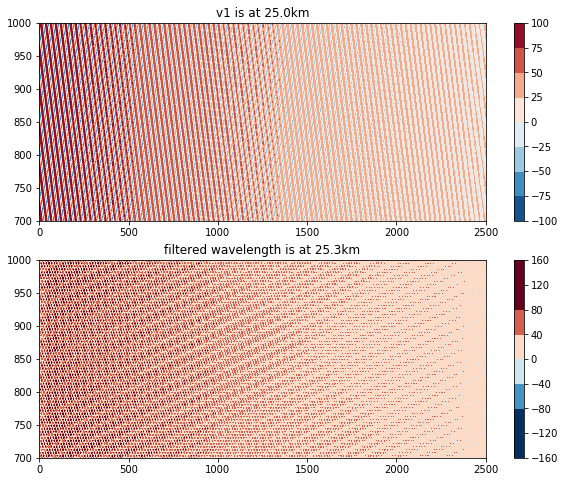

In [27]:
#calculate index closer to defined wavelength
wavelength_sel = lam1
wave_ind = int(np.where(np.abs(lambda_scales - wavelength_sel) == np.min(np.abs(lambda_scales - wavelength_sel)))[0])

fig, ax = plt.subplots(2,1,figsize=(10, 8))

fig0 = ax[0].contourf(x/1e3,y/1e3,np.transpose(v1),cmap="RdBu_r")
fig.colorbar(fig0,ax=ax[0])
ax[0].set_title("v1 is at {}km".format(lam1/1e3))
ax[0].set_xlim(0,2500)
ax[0].set_ylim(700,1000)

fig1 = ax[1].contourf(x/1e3,y/1e3,np.transpose(v_wf[wave_ind,:,:]/(2*np.pi)),cmap="RdBu_r",vmin=-100,vmax=100)
fig.colorbar(fig1,ax=ax[1])
ax[1].set_title("filtered wavelength is at {:.1f}km".format(lambda_scales[wave_ind]/1e3))
ax[1].set_xlim(0,2500)
ax[1].set_ylim(700,1000)

plt.show()


#### Filtered signal does not match up - Why is there an inner variability in the filtered signal?
- contamination from other components


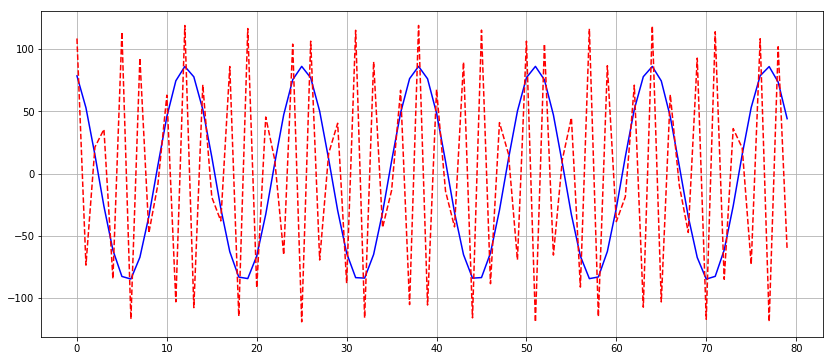

In [28]:
fig, ax = plt.subplots(1,figsize=(14, 6))

plt.plot(v1[60,60:140],color="b")
plt.plot(v_wf[wave_ind,60,60:140]/(2*np.pi),color="r",linestyle="--")

plt.grid()
plt.show()


#### Test wavelet on single component - v2 (forward and inverse transform should give back same signal)


In [29]:
#compute frequency spectrum of data 
v2_fft = np.fft.fft2(v2,axes=(0,1))
v2_fft = np.fft.fftshift(v2_fft,axes={0,1}) #recentre 0 

v2_wf = np.zeros(np.shape(psif))
for ss in np.arange(np.shape(psif)[0]):
    v2_wf[ss,:,:] = np.fft.ifft2(v2_fft * psif[ss,:,:],axes=(0,1))

/Users/jemimarama/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  import sys


/Users/jemimarama/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:2809: ComplexWarning: Casting complex values to real discards the imaginary part
  order=order, subok=True, ndmin=ndmin)
/Users/jemimarama/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'color', 'linestyle'
  s)


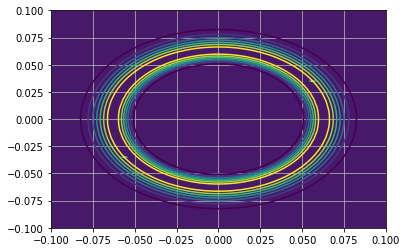

In [160]:
plt.contourf(fy,fx,(v2_fft*np.conj(v2_fft)))
plt.contour(fy,fx,psif[5,:,:],color="k",linestyle="--")
plt.xlim(-0.1,0.1)
plt.ylim(-0.1,0.1)
plt.grid()
plt.show()

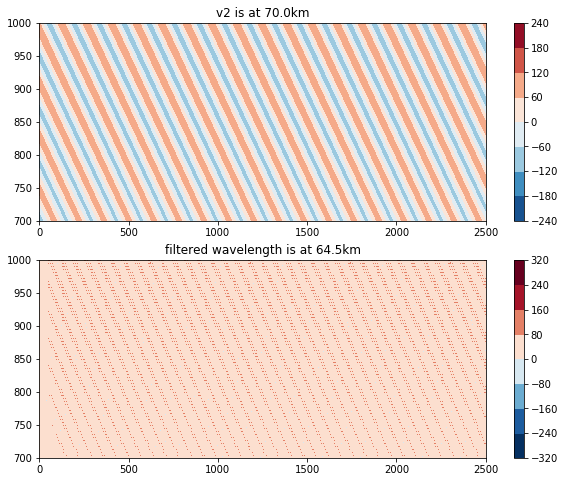

In [35]:
#calculate index closer to defined wavelength
wavelength_sel = lam2
wave_ind = int(np.where(np.abs(lambda_scales - wavelength_sel) == np.min(np.abs(lambda_scales - wavelength_sel)))[0])

fig, ax = plt.subplots(2,1,figsize=(10, 8))

fig0 = ax[0].contourf(x/1e3,y/1e3,np.transpose(v2),cmap="RdBu_r")
fig.colorbar(fig0,ax=ax[0])
ax[0].set_title("v2 is at {}km".format(lam2/1e3))
ax[0].set_xlim(0,2500)
ax[0].set_ylim(700,1000)

fig1 = ax[1].contourf(x/1e3,y/1e3,np.transpose(v2_wf[wave_ind,:,:]/(2*np.pi)),cmap="RdBu_r",vmin=-240,vmax=240)
fig.colorbar(fig1,ax=ax[1])
ax[1].set_title("filtered wavelength is at {:.1f}km".format(lambda_scales[wave_ind]/1e3))
ax[1].set_xlim(0,2500)
ax[1].set_ylim(700,1000)

plt.show()


#### Forward and inverse transforms do not match up (inner variability in the filtered signal)

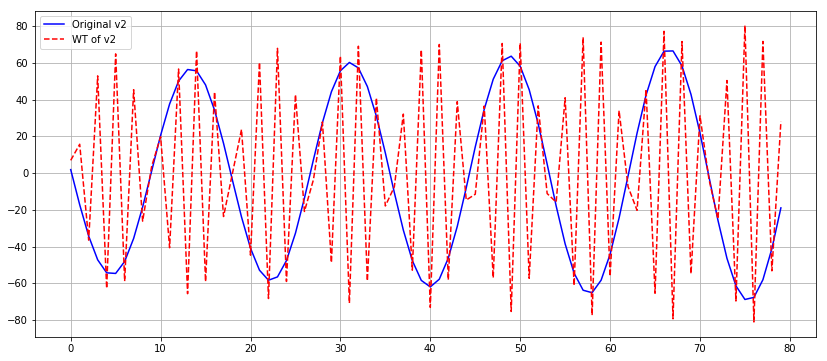

In [489]:
fig, ax = plt.subplots(1,figsize=(14, 6))

plt.plot(v2[60,60:140],color="b",label="Original v2")
plt.plot(v2_wf[wave_ind,60,60:140]/(2*np.pi),color="r",linestyle="--",label="WT of v2")

plt.grid()
plt.legend()
plt.show()


####  Solutions to get rid of inner variability
- Try specifying wavelength to define wavelet transform exactly at v1 wavenumber 
- Pad and damp edges to zero? FFt assumes a periodic signal 

/Users/jemimarama/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:2809: ComplexWarning: Casting complex values to real discards the imaginary part
  order=order, subok=True, ndmin=ndmin)


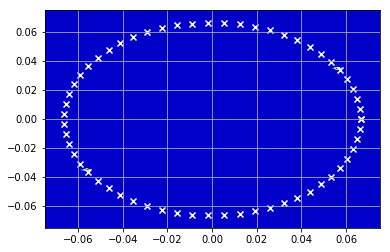

In [168]:
#specifying exact wavelength for scales 
test_fx = (kx2*dx)/(2*np.pi) #accounting for sampling interval and stuff
test_fy = (ky2*dy)/(2*np.pi)
test_fs = np.sqrt(test_fx**2 + test_fy**2)


#get series of fx and fy that gives a disk along test_fs
theta = np.linspace(0,2*np.pi,60)
fx_fs = test_fs*np.sin(theta)
fy_fs = test_fs*np.cos(theta)
         
plt.contourf(fy,fx,(v2_fft*np.conj(v2_fft)),cmap="jet")
plt.scatter(fy_fs,fx_fs,marker="x",color="w",linewidths=0.1)
plt.xlim(-0.075,0.075)
plt.ylim(-0.075,0.075)
plt.grid()
plt.show()



In [341]:
#compute frequency spectrum of data 
v1_fft = np.fft.fft2(v1,axes=(0,1))
v1_fft = np.fft.fftshift(v1_fft,axes={0,1}) #recentre 0 

v1_wf = np.zeros(np.shape(psif_test))
for ss in np.arange(np.shape(psif_test)[0]):
    v1_wf[ss,:,:] = np.fft.ifft2(v1_fft * psif_test[ss,:,:],axes=(0,1))

/Users/jemimarama/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  import sys


#### Check which wavelet encompasses peak

/Users/jemimarama/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:2809: ComplexWarning: Casting complex values to real discards the imaginary part
  order=order, subok=True, ndmin=ndmin)
/Users/jemimarama/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'color', 'linestyle'
  s)


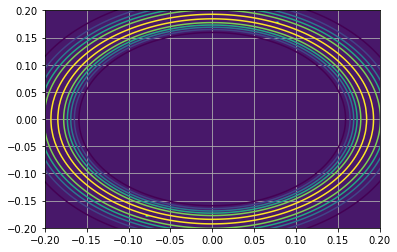

In [347]:
plt.contourf(fy,fx,(v1_fft*np.conj(v1_fft)))
plt.contour(fy,fx,psif_test[3,:,:],color="k",linestyle="--")
plt.xlim(-0.2,0.2)
plt.ylim(-0.2,0.2)
plt.grid()
plt.show()

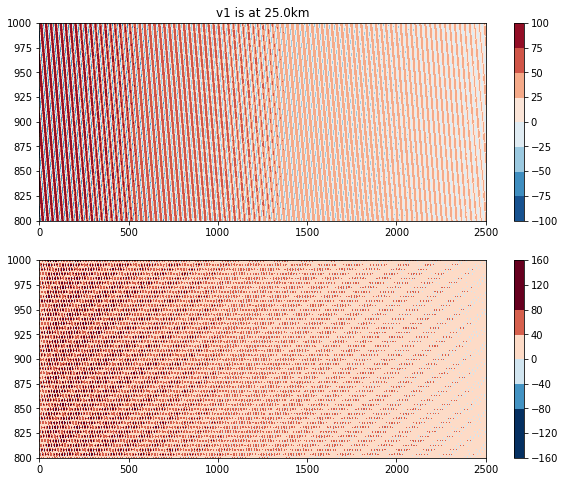

In [349]:
#calculate index closer to defined wavelength

fig, ax = plt.subplots(2,1,figsize=(10, 8))

fig0 = ax[0].contourf(x/1e3,y/1e3,np.transpose(v1),cmap="RdBu_r")
fig.colorbar(fig0,ax=ax[0])
ax[0].set_title("v1 is at {}km".format(lam1/1e3))
ax[0].set_xlim(0,2500)
ax[0].set_ylim(800,1000)

fig1 = ax[1].contourf(x/1e3,y/1e3,np.transpose(v1_wf[3,:,:]/(2*np.pi)),cmap="RdBu_r",vmin=-100,vmax=100)
fig.colorbar(fig1,ax=ax[1])
#ax[1].set_title("filtered wavelength is at {:.1f}km".format(lambda_scales[wave_ind]/1e3))
ax[1].set_xlim(0,2500)
ax[1].set_ylim(800,1000)

plt.show()


#### check if there is an inner varability?

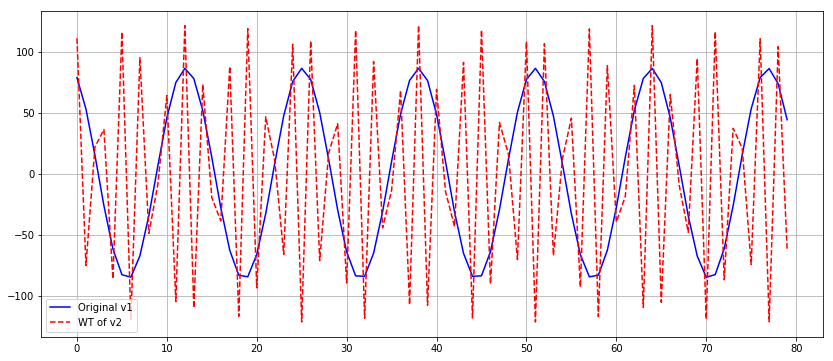

In [354]:
fig, ax = plt.subplots(1,figsize=(14, 6))

plt.plot(v1[60,60:140],color="b",label="Original v1")
plt.plot(v1_wf[3,60,60:140]/(2*np.pi),color="r",linestyle="--",label="WT of v2")

plt.grid()
plt.legend()
plt.show()


/Users/jemimarama/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:2809: ComplexWarning: Casting complex values to real discards the imaginary part
  order=order, subok=True, ndmin=ndmin)
/Users/jemimarama/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'color', 'linestyle'
  s)


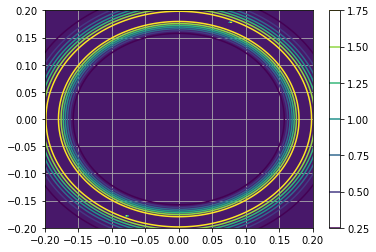

In [299]:
plt.contourf(fy,fx,(v1_fft*np.conj(v1_fft)))
plt.contour(fy,fx,psif_test[3,:,:],color="k",linestyle="--")
plt.xlim(-0.2,0.2)
plt.ylim(-0.2,0.2)
plt.colorbar()
plt.grid()
plt.show()

#### Apply cosine damping/or pad with zeros for boundary conditions


#### Padding data with zeros (zero boundary condition)

In [424]:
pad_x = np.zeros((1000,50))
pad_y = np.zeros((50,600))

v1_pad = np.concatenate((pad_x,v1,pad_x),axis=1)
v1_pad = np.concatenate((pad_y,v1_pad,pad_y),axis=0)


In [441]:
Nx = np.max(np.shape(v1_pad))
Ny = np.min(np.shape(v1_pad))

#grid for 2D fft 
fx = np.fft.fftshift(np.fft.fftfreq(Nx)) #returns cycles per unit of sampling (2pi already included) #sampling interval not included here
fy = np.fft.fftshift(np.fft.fftfreq(Ny))

#meshgrid of fx and fy
FY, FX = np.meshgrid(fy,fx)

grid_fxfy = np.sqrt(FX**2 + FY**2)

#compute frequency spectrum of data 
v1_fft = np.fft.fft2(v1_pad,axes=(0,1))
v1_fft = np.fft.fftshift(v1_fft,axes={0,1}) #recentre 0 


In [490]:
#use grid_fxfy
#use grid_fxfy
N = 100
K=1
ga=3
be=30
str="ene"
psif_test = morsewave(N,K,ga,be,grid_fxfy,str)

#replace NaNs with zeros
psif_test = np.nan_to_num(psif_test, copy=True)

/Users/jemimarama/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log
/Users/jemimarama/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/jemimarama/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/Users/jemimarama/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in subtract
/Users/jemimarama/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in multiply
  del sys.path[0]
/Users/jemimarama/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars


#### Can a particular wavelet encompass the peaks

/Users/jemimarama/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:2809: ComplexWarning: Casting complex values to real discards the imaginary part
  order=order, subok=True, ndmin=ndmin)
/Users/jemimarama/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'color', 'linestyle'
  s)


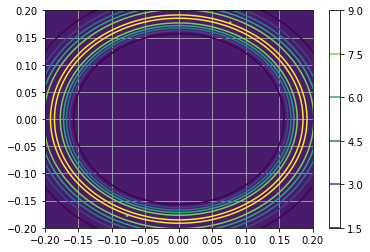

In [491]:
plt.contourf(fy,fx,(v1_fft*np.conj(v1_fft)))
plt.contour(fy,fx,psif_test[3,:,:],color="k",linestyle="--")
plt.xlim(-0.2,0.2)
plt.ylim(-0.2,0.2)
plt.colorbar()
plt.grid()
plt.show()

In [492]:
#apply wavelet transform

v1_wf = np.zeros(np.shape(psif_test))
for ss in np.arange(np.shape(psif_test)[0]):
    v1_wf[ss,:,:] = np.fft.ifft2(v1_fft * psif_test[ss,:,:],axes=(0,1))

/Users/jemimarama/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  """


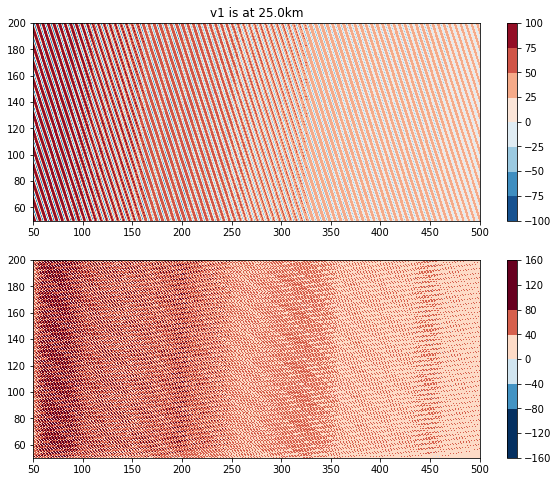

In [493]:
#calculate index closer to defined wavelength

fig, ax = plt.subplots(2,1,figsize=(10, 8))

fig0 = ax[0].contourf(np.transpose(v1_pad),cmap="RdBu_r")
fig.colorbar(fig0,ax=ax[0])
ax[0].set_title("v1 is at {}km".format(lam1/1e3))
ax[0].set_xlim(50,500)
ax[0].set_ylim(50,200)

fig1 = ax[1].contourf(np.transpose(v1_wf[3,:,:]/(2*np.pi)),cmap="RdBu_r",vmin=-100,vmax=100)
fig.colorbar(fig1,ax=ax[1])
#ax[1].set_title("filtered wavelength is at {:.1f}km".format(lambda_scales[wave_ind]/1e3))
ax[1].set_xlim(50,500)
ax[1].set_ylim(50,200)

plt.show()

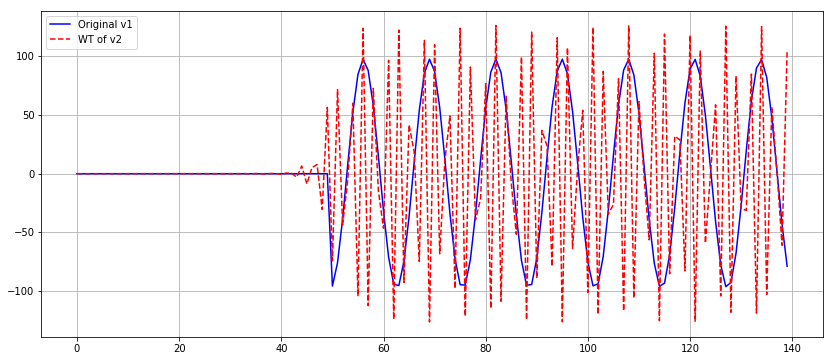

In [494]:
fig, ax = plt.subplots(1,figsize=(14, 6))

plt.plot(v1_pad[60,0:140],color="b",label="Original v1")
plt.plot(v1_wf[3,60,0:140]/(2*np.pi),color="r",linestyle="--",label="WT of v2")

plt.grid()
plt.legend()
plt.show()


#### Heisenberg area 